# Import Libraries & Packages

In [68]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns

In [2]:
import sys
sys.path.append('../lending_club')
import config

# Import Approved Loan Data

In [ ]:
from data_prep import get_lending_club_data
accepted_loans = get_lending_club_data(config.APPROVED_LOANS_CSV)

In [ ]:
accepted_loans.to_parquet(config.DATAPATH / 'approved.parquet', engine='fastparquet', compression = 'GZIP')

In [3]:
approved = pd.read_parquet('../data/approved.parquet', engine='fastparquet')

### Create Average FICO Score

In [56]:
approved['fico_range_average'] = (approved['fico_range_high'] + approved['fico_range_low']) / 2

#### What are the interest rates for each loan grade?

[Text(0, 0.5, 'Sub Grade'),
 Text(0.5, 0, 'Interest Rate'),
 Text(0.5, 1.0, 'Interest Rate by Sub Grade')]

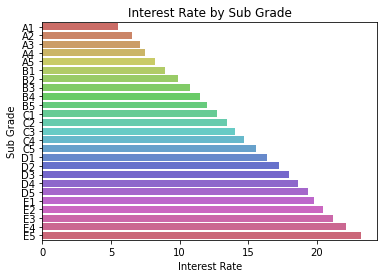

In [18]:
byGrade = approved.groupby(['sub_grade'])[['int_rate']].mean().reset_index()

fig = sns.barplot(
    data = byGrade,
    y = 'sub_grade', x = 'int_rate', palette = 'hls')

fig.set(title = 'Interest Rate by Sub Grade', ylabel = 'Sub Grade', xlabel = 'Interest Rate')

#### Which states are the most common?

In [35]:
approved['addr_state'].value_counts().head(5)

CA    190540
TX    106795
NY    106201
FL     92665
IL     50209
Name: addr_state, dtype: int64

In [36]:
pop = pd.read_csv('../data/population.csv', skiprows = 3)
pop = pop.iloc[5:56]
pop.rename(columns = {'Unnamed: 0': 'State'}, inplace = True)
pop.drop(['Census', 'Estimates Base', '2019'], axis = 1, inplace = True)

In [37]:
pop['State'] = pop['State'].str.replace('.','')

<ipython-input-37-445b849bc40a>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  pop['State'] = pop['State'].str.replace('.','')


In [38]:
# Dropped District of Columbia
pop.drop(index = 13, inplace = True)

In [39]:
for column in ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']:
    pop[column] = pop[column].str.replace(',','').astype(int)

In [40]:
State = {
'Alabama': 'AL',
'Alaska': 'AK',
'Arizona': 'AZ',
'Arkansas': 'AR',
'California': 'CA',
'Colorado': 'CO',
'Connecticut': 'CT',
'Delaware': 'DE',
'Florida': 'FL',
'Georgia': 'GA',
'Hawaii': 'HI',
'Idaho': 'ID',
'Illinois': 'IL',
'Indiana': 'IN',
'Iowa': 'IA',
'Kansas': 'KS',
'Kentucky': 'KY',
'Louisiana': 'LA',
'Maine': 'ME',
'Maryland': 'MD',
'Massachusetts': 'MA',
'Michigan': 'MI',
'Minnesota': 'MN',
'Mississippi': 'MS',
'Missouri': 'MO',
'Montana': 'MT',
'Nebraska': 'NB',
'Nevada': 'NV',
'New Hampshire': 'NH',
'New Jersey': 'NJ',
'New Mexico': 'NM',
'New York': 'NY',
'North Carolina': 'NC',
'North Dakota': 'ND',
'Ohio': 'OH',
'Oklahoma': 'OK',
'Oregon': 'OR',
'Pennsylvania': 'PA',
'Rhode Island': 'RI',
'South Carolina': 'SC',
'South Dakota': 'SD',
'Tennessee': 'TN',
'Texas': 'TX',
'Utah': 'UT',
'Vermont': 'VT',
'Virginia': 'VA',
'Washington': 'WA',
'West Virginia': 'WV',
'Wisconsin': 'WI',
'Wyoming': 'WY'
}

In [41]:
pop['State Abbr'] = pop['State'].replace(State)

In [42]:
pop['Avg Population'] = (pop['2010'] + pop['2011'] + pop['2012'] + pop['2013'] + pop['2014'] + pop['2015'] + pop['2016'] + pop['2017'] + pop['2018']) / 9
pop['Avg Population'] = pop['Avg Population'].astype(int)

In [43]:
pop = pop.iloc[:,10:]

In [44]:
pop = pop.merge(pd.DataFrame(approved['addr_state'].value_counts().reset_index()).rename(columns = {'index': 'State Abbr'}))

In [45]:
pop['Loans per Capita'] = pop['addr_state'] / pop['Avg Population']

In [46]:
pop['Loans per Capita'] = round(pop['Loans per Capita'], 5) * 10000

In [47]:
byCapita = pop.sort_values(by = 'Loans per Capita', ascending = False).head(10)

[Text(0, 0.5, 'Loans per 10,000 residents'),
 Text(0.5, 0, 'State'),
 Text(0.5, 1.0, 'Top 10 States')]

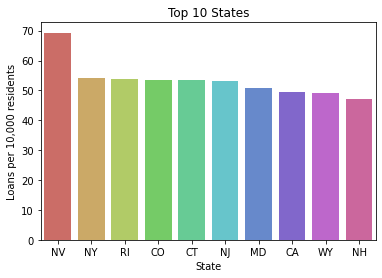

In [48]:
fig = sns.barplot(
    data = byCapita,
    y = 'Loans per Capita', x = 'State Abbr', palette = 'hls')

fig.set(title = 'Top 10 States', ylabel = 'Loans per 10,000 residents', xlabel = 'State')

### Most Frequent Zip Codes

In [79]:
approved['zip_code'].value_counts().head(10)

945xx    14555
750xx    14029
112xx    13339
606xx    12090
300xx    11699
331xx    10968
070xx    10424
891xx    10294
100xx    10273
900xx    10267
Name: zip_code, dtype: int64

- 945: Oakland, CA - Vicinity
- 750: Dallas, TX - North
- 112: Brooklyn, NY
- 606: Chicago, IL - Main1
- 300: Atlanta, GA - East
- 331: Miami, FL - Main1
- 070: Newark, NJ - Vicinity
- 891: Las Vegas, NV - Main
- 100: New York, NY - Main
- 900: Los Angeles, CA - Main

#### What loan durations are most common?

In [49]:
byDuration = pd.DataFrame(approved['term'].value_counts()).reset_index()
byDuration.rename(columns = {'index': 'term', 'term': 'count'}, inplace = True)

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Loan Duration (in months)'),
 Text(0.5, 1.0, 'Loan Durations')]

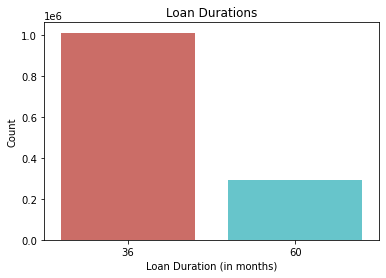

In [52]:
fig = sns.barplot(y = 'count', x = 'term', data = byDuration, palette = 'hls')

fig.set(title = 'Loan Durations', ylabel = 'Count', xlabel = 'Loan Duration (in months)')

#### What are the most common loan purposes?

In [25]:
byPurpose = pd.DataFrame(approved['purpose'].value_counts()).reset_index()
byPurpose.rename(columns = {'index': 'purpose', 'purpose': 'count'}, inplace = True)
byPurpose = byPurpose.sort_values('count', ascending = False)

[Text(0, 0.5, 'Loan Purpose'), Text(0.5, 1.0, 'Frequency of Loan Purposes')]

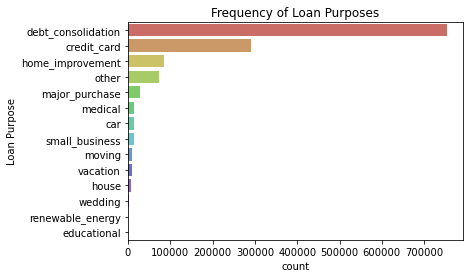

In [30]:
fig = sns.barplot(y = 'purpose', x = 'count', data = byPurpose, palette = 'hls')

fig.set(title = 'Frequency of Loan Purposes', ylabel = 'Loan Purpose')

###

[Text(0, 0.5, 'Loan Purpose'), Text(0.5, 1.0, 'Frequency of Loan Purposes')]

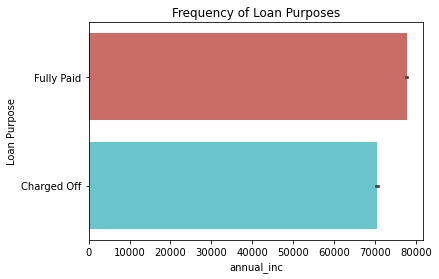

In [83]:
fig = sns.barplot(y = 'loan_status', x = 'annual_inc', data = approved, palette = 'hls')

fig.set(title = 'Frequency of Loan Purposes', ylabel = 'Loan Purpose')

In [70]:
approved['loan_status'] = np.where(approved['loan_status']== 0,'Charged Off', 'Fully Paid')

In [71]:
approved['loan_status']

id
54734         Fully Paid
55716         Fully Paid
55742         Fully Paid
56121        Charged Off
56705         Fully Paid
                ...     
145620416     Fully Paid
145622746     Fully Paid
145623694     Fully Paid
145627026     Fully Paid
145636374     Fully Paid
Name: loan_status, Length: 1303083, dtype: object

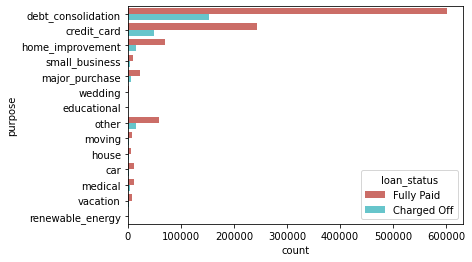

In [77]:
fig = sns.countplot(
    data=approved, y="purpose", hue="loan_status", palette = 'hls'
)

In [94]:
g = approved[approved['annual_inc'] < 150000]

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

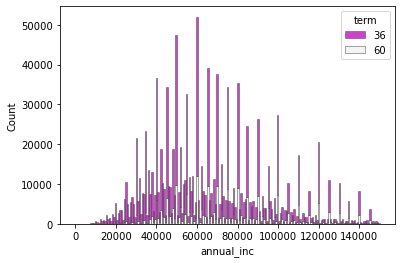

In [95]:
sns.histplot(
    data = g,
    x="annual_inc", hue="term",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5
).xlim(0,150000)

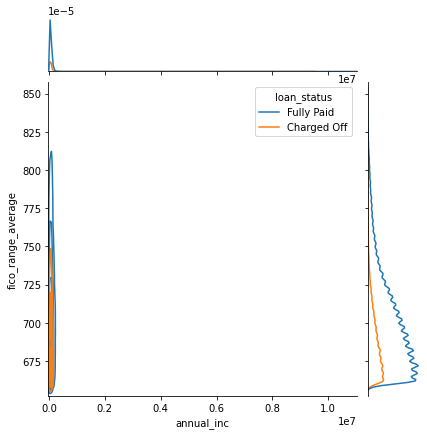

In [93]:
sns.jointplot(data=approved, x="annual_inc", y="fico_range_average", hue="loan_status", kind="kde")

In [64]:
approved.columns

Index(['addr_state', 'annual_inc', 'application_type', 'disbursement_method',
       'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high',
       'fico_range_low', 'grade', 'home_ownership', 'initial_list_status',
       'installment', 'int_rate', 'issue_d', 'loan_amnt', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'sub_grade', 'term',
       'verification_status', 'zip_code', 'loan_status', 'fico_range_average'],
      dtype='object')